# Global Forecasting System - Temperature profiles in the atmosphere

In [1]:
from datetime import datetime, timedelta
import xarray
import numpy as np
import pandas as pd
from mikeio import Dfs3

Let's try to download yesterday's forecast from the OpenDAP server.

In [2]:
now = datetime.now()

forecast = datetime(now.year,now.month,now.day) - timedelta(days=1)

In [ ]:
dtstr = forecast.strftime("%Y%m%d")
hour = "12" # valid options are 00,06,12,18
url = f"https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs{dtstr}/gfs_0p25_{hour}z"
ds = xarray.open_dataset(url)

Create a small subset of the data to make it faster to download.

In [4]:
ds = ds.sel(lon=slice(10,15), lat=slice(54,58)).isel(time=slice(0,2))

Temperature on pressure levels in the atmosphere is named *tmpprs*

In [5]:
ds.tmpprs

<xarray.DataArray 'tmpprs' (time: 2, lev: 41, lat: 17, lon: 21)>
array([[[[291.74896, ..., 287.94894],
         ...,
         [289.31897, ..., 292.59897]],

        ...,

        [[176.74976, ..., 175.60976],
         ...,
         [176.60976, ..., 176.16977]]],


       [[[292.26175, ..., 288.30176],
         ...,
         [290.60175, ..., 292.87177]],

        ...,

        [[175.89532, ..., 176.85533],
         ...,
         [177.92532, ..., 174.71533]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-08-31T12:00:00 2021-08-31T15:00:00
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.07 0.04 0.02 0.01
  * lat      (lat) float64 54.0 54.25 54.5 54.75 55.0 ... 57.25 57.5 57.75 58.0
  * lon      (lon) float64 10.0 10.25 10.5 10.75 11.0 ... 14.25 14.5 14.75 15.0
Attributes:
    long_name:  ** (1000 975 950 925 900.. 10 7 4 2 1) temperature [k]

In [6]:
ds.lev

<xarray.DataArray 'lev' (lev: 41)>
array([1.00e+03, 9.75e+02, 9.50e+02, 9.25e+02, 9.00e+02, 8.50e+02, 8.00e+02,
       7.50e+02, 7.00e+02, 6.50e+02, 6.00e+02, 5.50e+02, 5.00e+02, 4.50e+02,
       4.00e+02, 3.50e+02, 3.00e+02, 2.50e+02, 2.00e+02, 1.50e+02, 1.00e+02,
       7.00e+01, 5.00e+01, 4.00e+01, 3.00e+01, 2.00e+01, 1.50e+01, 1.00e+01,
       7.00e+00, 5.00e+00, 3.00e+00, 2.00e+00, 1.00e+00, 7.00e-01, 4.00e-01,
       2.00e-01, 1.00e-01, 7.00e-02, 4.00e-02, 2.00e-02, 1.00e-02])
Coordinates:
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.07 0.04 0.02 0.01
Attributes:
    grads_dim:      z
    grads_mapping:  levels
    units:          millibar
    long_name:      altitude
    minimum:        1000.0
    maximum:        0.01
    resolution:     24.99975

Level 0 = 1000 mbar, i.e. close to the ground.

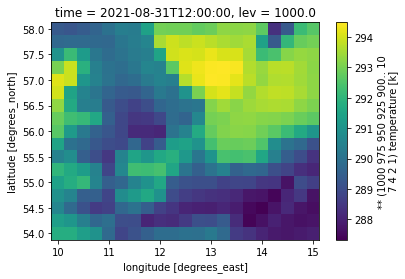

In [7]:
ds.tmpprs.isel(time=0,lev=0).plot()

Top level = 0.4 mbar, i.e. at the top of the atmosphere.

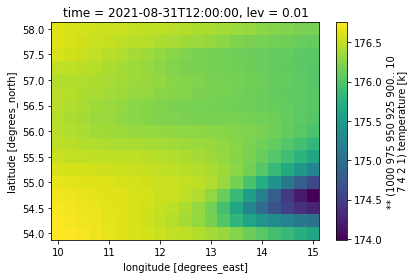

In [8]:
ds.tmpprs.isel(time=0,lev=-1).plot()

Let's look at a profile

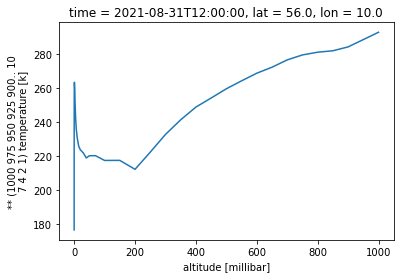

In [9]:
ds.tmpprs.sel(lon=10,lat=56).isel(time=0).plot()

## Convert to dfs3

Dfs3 does not support irregularly spaced spatial axis as is used by the vertical coordinate axis in this case (pressure levels).

**Thus, please note that the vertical coordinates are not correct in this example.**

In [10]:
lat = ds.lat.values
lon = ds.lon.values
lev = ds.lev.values

nx = len(lon)
ny = len(lat)
nz = len(lev)

x0 = lon[0]
y0 = lat[0]

dx = np.round((lon[-1] - lon[0]) / (nx-1),2)
dy = np.round((lat[-1] - lat[0]) / (ny-1),2)

x0, y0, nx, ny, dx, dy

(10.0, 54.0, 21, 17, 0.25, 0.25)

## Time

In [11]:
t = ds.time.values
print(t[0])
start_time = pd.to_datetime(t).to_pydatetime()[0]

2021-08-31T12:00:00.000000000


## Variable types

In [ ]:
from mikeio.eum import EUMType
EUMType.Temperature

In [ ]:
EUMType.Temperature.units

# Data manipulation
Flip upside / down

In [14]:
temperature = ds.tmpprs.values

temperature = np.flip(temperature,axis=1)

In [15]:
from mikeio.eum import ItemInfo, EUMUnit
     
dfs = Dfs3()
dfsfilename = f"gfs_{dtstr}_{hour}_temperature_profile.dfs3"
dfs.write(filename=dfsfilename,
           data=[temperature],
           start_time = start_time,
           dt=3600,
           items=[ItemInfo(EUMType.Temperature, EUMUnit.degree_Kelvin)],
           coordinate=['LONG/LAT', x0, y0, 0],
           dx=dx, dy=dy
)

## Clean up (don't run this)

In [16]:
import os
os.remove(dfsfilename)